In [1]:
from imutils import face_utils
import matplotlib.pyplot as plt
import cv2
import dlib
import pywt
import os
import math
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Dropout
from keras.layers import Conv2D,MaxPooling2D, GlobalAveragePooling2D
from keras.layers import BatchNormalization
from keras.layers import Activation,Dense,Flatten
from keras.models import Sequential,load_model
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
train_folder = '/home/vishwajeet/Documents/Summer_Project_FER/images_with_neutral/'
expres_code = ['NE','HA','AN','DI','FE','SA','SU']
expressions = [ 0,   1,   2,   3,   4,   5,   6]

In [3]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/home/vishwajeet/Documents/Summer_Project_FER/shape_predictor_68_face_landmarks.dat')

In [4]:
def read_data(dir_path):
    img_names = []
    img_data_list = []
    labels = []
    img_list = os.listdir(dir_path)
    for img in img_list:
        input_img = cv2.imread(dir_path + img, cv2.IMREAD_GRAYSCALE)
        img_data_list.append(input_img)
        label = img[3:5]  # each name of image have 2 char for label from index 3-5
        labels.append(expres_code.index(label))
        img_names.append(img)
    img_data = np.array(img_data_list)

    print(img_data)
    return img_data, labels, img_names

def rotateImage(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

def angle_line_x_axis(point1, point2):
    angle_radian = math.atan2(point1[1] - point2[1], point1[0] - point2[0]);
    angle_degree = angle_radian * 180 / math.pi;
    return angle_degree

def detect_eyes(gray):
    rects = detector(gray, 1)
    # loop over the face detections
    for (i, rect) in enumerate(rects):
        # determine the facial landmarks for the face region, then
        # convert the landmark (x, y)-coordinates to a NumPy array
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)
        
        pts_right = shape[36 : 42]   # right eye landmarks
        pts_left = shape[42 : 48]    # left eye landmarks
        
        hull_right = cv2.convexHull(pts_right)
        M_right = cv2.moments(hull_right)
        # calculate x,y coordinate of center
        cX_right = int(M_right["m10"] / M_right["m00"])
        cY_right = int(M_right["m01"] / M_right["m00"])
        right_eye_center = (cX_right, cY_right)
        
        hull_left = cv2.convexHull(pts_left)
        M_left = cv2.moments(hull_left)
        # calculate x,y coordinate of center
        cX_left = int(M_left["m10"] / M_left["m00"])
        cY_left = int(M_left["m01"] / M_left["m00"])
        left_eye_center = (cX_left, cY_left)

    return left_eye_center, right_eye_center

def preprocessing(input_images):
    normalized_faces = []
    for gray in input_images:
        left_eye, rigth_eye = detect_eyes(gray)
        
        angle = angle_line_x_axis(left_eye, rigth_eye)
        rotated_img = rotateImage(gray, angle)
        
        # line length
        D = cv2.norm(np.array(left_eye) - np.array(rigth_eye))
        
        # center of the line
        D_point = [(left_eye[0] + rigth_eye[0]) / 2, (left_eye[1] + rigth_eye[1]) / 2]
        
        # Face ROI
        x_point = int(D_point[0] - (0.9 * D))
        y_point = int(D_point[1] - (0.6 * D))
        width_point = int(1.8 * D)
        height_point = int(2.2 * D)
        r = [x_point, y_point, width_point, height_point]
        face_roi = rotated_img[int(r[1]):int(r[1]+r[3]), int(r[0]):int(r[0]+r[2])]
        face_roi = cv2.resize(face_roi,(128,128))
        face_roi = cv2.equalizeHist(face_roi)
        normalized_faces.append(face_roi)
    return normalized_faces

In [5]:
X, Y, img_names = read_data(train_folder)
cropped_X = preprocessing(X)
cropped_X[0].shape
img_x=np.array(cropped_X)
img_x.shape

[[[ 96 106 106 ...  98  98  97]
  [112 107  95 ... 100 103  96]
  [103 103  97 ... 101  94 102]
  ...
  [ 40  37  42 ... 104 111 102]
  [ 43  47  50 ...  99 102  98]
  [ 44  49  54 ... 100 108 106]]

 [[119 118 118 ... 102 112 103]
  [121 118 122 ... 114 103 104]
  [137 128 116 ... 109 104 100]
  ...
  [ 47  49  60 ... 115 111 111]
  [ 50  65  73 ... 111 113 106]
  [ 73  81  75 ... 106 111 109]]

 [[ 66  67  68 ... 140 146 143]
  [ 94  96  94 ... 150 146 139]
  [116 115 117 ... 138 130 137]
  ...
  [ 73  62  59 ... 143 130 131]
  [ 62  60  56 ... 132 133 131]
  [ 54  49  53 ... 137 143 144]]

 ...

 [[143 137 130 ... 112 115 114]
  [136 139 135 ... 113 109 115]
  [140 139 134 ... 107 117 105]
  ...
  [ 50  50  43 ... 121 114 115]
  [ 55  48  46 ... 115 115 112]
  [ 52  49  46 ... 114 121 115]]

 [[ 68  61  65 ... 154 154 151]
  [ 70  66  63 ... 152 153 150]
  [ 73  70  76 ... 139 148 155]
  ...
  [ 36  38  40 ... 142 131 139]
  [ 36  40  30 ... 138 146 141]
  [ 31  33  32 ... 131 137 1

(213, 128, 128)

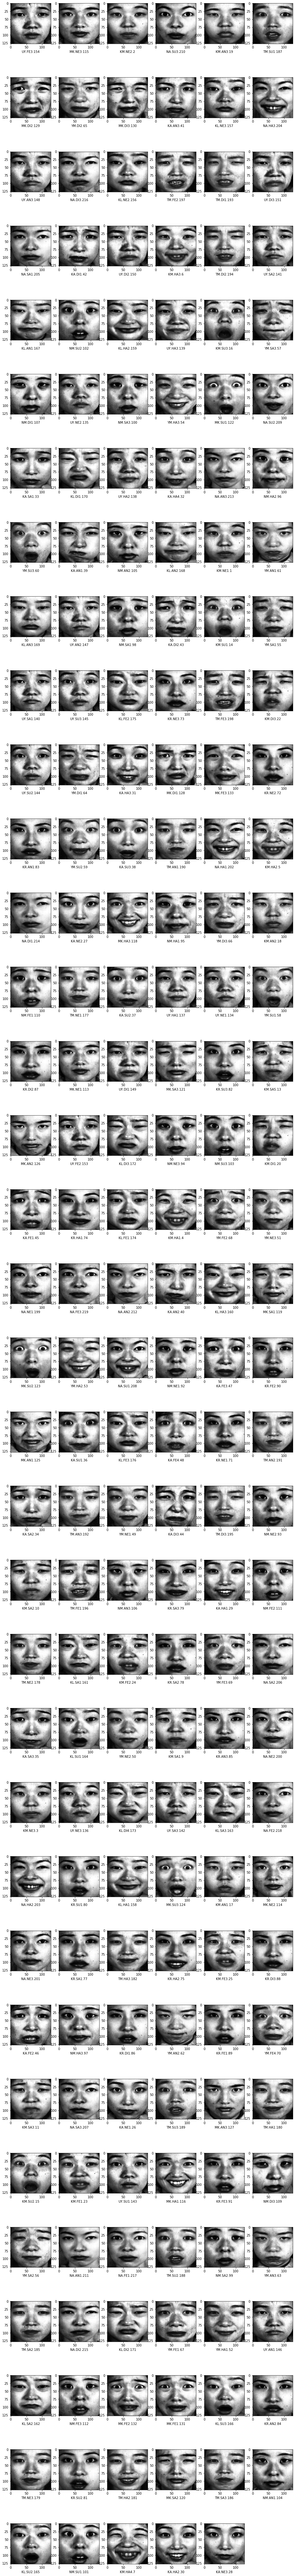

In [6]:
fig=plt.figure(figsize=(16, 150))
columns = 6
rows = int(len(cropped_X)/columns)
for i in range(1, columns*rows):
    img = cropped_X[i]
    ax = fig.add_subplot(rows, columns, i)
    type_name = img_names[i][:-5]
    ax.set_xlabel(type_name)
    plt.imshow(img, cmap = 'gray')
plt.show()


In [11]:
labels_encoding = pd.get_dummies(Y, sparse=True)
labelenc= np.asarray(labels_encoding)
# print(labelenc.shape)
# print(labelenc[:43])
x_train, x_test, y_train, y_test = train_test_split(img_x, 
                                                    labelenc, 
                                                    test_size=0.2, 
                                                    stratify=np.array(labelenc), 
                                                    random_state=4)

In [12]:
rows=128
cols=128
x_train=x_train.reshape(x_train.shape[0],rows,cols,1)
x_test=x_test.reshape(x_test.shape[0],rows,cols,1)

input_shape=(rows,cols,1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255.0
x_test = x_test / 255.0
x_train.shape,x_test.shape

((170, 128, 128, 1), (43, 128, 128, 1))

In [13]:
model = Sequential()

model.add(Conv2D(filters=64,kernel_size=(3,3),input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=128,kernel_size=(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=256,kernel_size=(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(7))
model.add(Activation('softmax'))

#model.compile(loss = "mean_squared_error",optimizer = Adam(), metrics=['accuracy'],)



In [14]:
model.compile(loss = "categorical_crossentropy",optimizer = Adam(), metrics=['accuracy'],)
BATCH_SIZE=85
epochs=50

model.fit(x_train, y_train,epochs=epochs, batch_size=BATCH_SIZE,verbose=1)

model.save('jaffe_model_with_neutral.h5')

Epoch 1/50
170/170 [==============================] - 42s 247ms/step - loss: 2.5735 - accuracy: 0.1471
Epoch 2/50
170/170 [==============================] - 6s 36ms/step - loss: 2.0922 - accuracy: 0.1765
Epoch 3/50
170/170 [==============================] - 4s 25ms/step - loss: 1.9417 - accuracy: 0.1588
Epoch 4/50
170/170 [==============================] - 4s 25ms/step - loss: 1.9331 - accuracy: 0.1529
Epoch 5/50
170/170 [==============================] - 4s 25ms/step - loss: 1.9187 - accuracy: 0.2235
Epoch 6/50
170/170 [==============================] - 5s 27ms/step - loss: 1.8991 - accuracy: 0.2235
Epoch 7/50
170/170 [==============================] - 9s 51ms/step - loss: 1.8635 - accuracy: 0.2941
Epoch 8/50
170/170 [==============================] - 5s 29ms/step - loss: 1.8122 - accuracy: 0.3412
Epoch 9/50
170/170 [==============================] - 5s 28ms/step - loss: 1.7087 - accuracy: 0.4294
Epoch 10/50
170/170 [==============================] - 5s 27ms/step - loss: 1.5806 - accu

In [16]:
model = load_model("jaffe_model_with_neutral.h5")

model.compile(loss = "categorical_crossentropy",optimizer = Adam(), metrics=['accuracy'],)

loss, acc = model.evaluate(x_test, y_test)
print('ACCURACY: ', acc)

43/43 [==============================] - 1s 22ms/step
ACCURACY:  0.9069767594337463


In [17]:
y_prediction = model.predict_classes(x_test)
y_test_original=np.argmax(y_test,axis=1)
confusion=confusion_matrix(y_true=y_test_original, y_pred=y_prediction)
print(confusion)

[[5 0 0 0 0 1 0]
 [0 5 0 0 1 0 0]
 [0 0 6 0 0 0 0]
 [0 0 0 6 0 0 0]
 [0 0 0 0 6 0 1]
 [0 0 0 0 1 5 0]
 [0 0 0 0 0 0 6]]


In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 64)      640       
_________________________________________________________________
activation_1 (Activation)    (None, 126, 126, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 128)       73856     
_________________________________________________________________
activation_2 (Activation)    (None, 61, 61, 128)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 256)      